### Rule based resistance prediction script

**This script takes genetic inputs and produces amoxicillin, basic (beta-lactamase only) and extended amoxicillin-clavulanate resistance predictions**

Input files it uses. 
- ariba_reports.tar.gz => Raw ARIBA reports (note this produces a directory with a report for each file)
- ariba_assembly.tar.gz => Raw ARIBA assemblies (note this produces a directory with a assembly for each file)
- genetic_inputs_for_resistance_prediction.csv => This is a parsed version of the ARIBA reports, which of note re-aligns mutations using BLAST (as ARIBA uses DNA matching, some of its alignments are not optimal resulting in spurious differences (SNV and mutations) being identified 

It also uses a "basic_rules.csv" which defines what phenotype each beta-lactamase is expected to give.


**After this it then goes on to compare these predictions with phenotypes , producing figures 2 and 4 from the paper**


#### Required Modules
1. Biopython
2. Pandas
3. Numpy
3. Matplotlib
4. Seaborn
5. Pylab

In [1]:

# In built python
from collections import Counter
import csv
import os
import subprocess
import json
from copy import deepcopy

# Biopython
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# PANDAS NUMPY
import pandas as pd
import numpy as np

# seaborn
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import *


**First unpacking the report tar files**

In [2]:
# Note prior to everything else you will need to unpack the assembly and report tarballs to get the files in them

subprocess.check_call("tar -zxvf ariba_reports.tar.gz", shell=True)
subprocess.check_call("tar -zxvf ariba_assembly.tar.gz", shell=True)

0

**Then reading in the data they contain**

In [3]:
# Reading in files

ariba_assemfiles = [os.path.join(root, f) for root, dirs, files in os.walk("ariba_assembly_20200109") 
                    for f in files if "assembly.fa" in f]
ariba_reportfiles = [os.path.join(root, f) for root, dirs, files in os.walk("ariba_reports_20200109") 
                    for f in files if "aribareport.tsv" in f]
basic_rules = pd.read_csv("basic_rules.csv") # This summarizes by element rules for basic prediction (based on BUSH JACOBY classes)
in_agardil = list(pd.read_csv("agar_dilution_phenotypes.csv").isolate) # The agar dilution phenotypes, here I'm using it just to get an easy list of the agar dilution samples
guuids = list(pd.read_csv("bd_phoenix_mics.csv").isolate) # The full set phenotypes (likewise)
res_file = pd.read_csv("genetic_inputs_for_resistance_prediction.csv") # IMPORTANT FILE, THIS IS OUR SUMMARY OF THE ARIBA OUTPUT. NOTE WE USE BLAST MUTATIONS AS ARIBA DOES NOT PROTEIN ALIGN
ariba_reportfiles = {k.split("/")[1].rstrip("_aribareport.tsv"):k for k in ariba_reportfiles}
ariba_assemfiles  = {k.split("/")[1].rstrip("_assembly.fa"):k for k in ariba_assemfiles}
# Defining resistance prediction rules, see paper for a more comprehensive/understandable explanation of them


#### Now onto resistance prediction

**This cell deals with the first step, defining the resistance prediction rules**

for each rule, left is how it is coded in, and to the right describes the biological feature it is marking
We then also convert these into lists to make downstream analysis simpler

**Note to keep parity with an original version, this contains a prediction 9, an ampC promoter mutation, 134 G>A which was initially suspected (from a literature search) to give amoxicillin-clavulanate resistance HOWEVER WHEN INTERROGATED INDIVIDUALLY IT DEMONSTRATABLY DIDNT We have left this in here as downstream code relied on numbering system, however it plays no role in resistancePrediction**

In [4]:
# Defining rules

rule_1 = list(basic_rules.loc[basic_rules['rule_set']==1]['ele']) #CLASS C/D serine BLM
rule_2 = list(basic_rules.loc[basic_rules['rule_set']==2]['ele']) #IR CLASS A serine BLM
rule_3 = ["C:37:T"] # PA/PB
rule_4_dels = ["C:36:-","C:37:-","T:38:-","A:39:-","T:40:-","T:41:-","T:42:-","T:43:-","T:44:-","T:45:-"] #PC/PD
sequential_subsets = []
for i in range(4):
    sequential_subsets.append(rule_4_dels[i:i+5])
rule_4_dels = sequential_subsets
rule_4_snvs = ["T:56:A"] # PC/PD
rule_5 = ["G:167:T"] # P4
rule_6 = ["C:146:G"] # P5
rule_7 = ["C:110:T"] # -42 C->T ampC promoter mutation
rule_8 = ["T:120:A"] # -32 T->A ampC promoter mutation
rule_9 = ["G:134:A"] # -18 G->A ampC promoter mutation # NOW DEFUNCT
rule_10 = ["C:175:A" ] # +24 C->A ampC promoter mutation
rule_11 = list(range(117,145)) # ampC promoter insertion range
rule_12 = 2.5 # copy_number cutoff
rule_13 = ['assembled_into_one_contig','complete_gene', 'unique_contig'] #ompC/F good flags
rule_14 = ['hit_both_strands','region_assembled_twice', 'scaffold_graph_bad'] # ompC/F Bad flags
rule_15 = [89.5 , 89.5] # PID and length cutoff for gene
#NOTE FOR RULES 13-15 there must be a beta-lactamase
# Note for rule 3-6 there must be a blaTEM

# Useful other lists
all_elements = [i for i in list(basic_rules['ele'])]
bla_tems = [i for i in list(basic_rules['ele']) if "blaTEM" in i]
extras = ['TEMP3_promoter_1_NA', 'ampC_promoter_1_NA', 'ompC_1_NC_000913', 'ompF_1_NC_000913']
blas = [i for i in all_elements if i not in extras]
ompcs = ['ompC_1_NC_000913', 'ompF_1_NC_000913']

#### Now, for each sample we use the rules above to predict resistance. 

This is done using the sample class
This in essence has the following steps
1. all relevant data for the sample
    - Note for this analysis we have not used the minor allele frequency type information in HETS (i.e. the possibility of 2 allelic variants in the same isolate)
    - Also we require elements to have an average coverage of greater then 10x
2. applys a test function for each rule 
        - self.rule_1 = self.rule_1_test()
        - self.rule_2 = self.rule_2_test()
        - self.rule_3 = self.rule_3_test()
        - self.rule_4 = self.rule_4_test()
        - self.rule_5 = self.rule_5_test()
        - self.rule_6 = self.rule_6_test()
        - self.rule_7 = self.rule_7_test()
        - self.rule_8 = self.rule_8_test()
        - self.rule_9 = self.rule_9_test()
        - self.rule_10 = self.rule_10_test()
        - self.rule_11 = self.rule_11_test()
        - self.rule_12 = self.rule_12_test()
3. Use the combined rules to make the resistance predictions
        - self.amx = self.amx_predictor()
        - self.coab = self.coa_bpredictor()
        - self.coae = self.coa_epredictor()
4. Write output files
    - 1 containing resistance predictions  (resistance_predictions.csv)
    - 1 containing inputs for the modelling process (model_elements_and_coverages.json)

In [5]:


# Useful functions

def choose_best(triplet_list):
    triplet_list = sorted(triplet_list, key = lambda a : a[0] + a[1] + a[2])
    
def make_mean_cov(tuple_l):
    bottom = sum([i[1] for i in tuple_l])
    top = sum([i[0]*i[1] for i in tuple_l])
    return top/bottom


class sample:
    
    
    def __init__(self, guuid):
        self.guuid = guuid
        self.is_in_agardil = (self.guuid in in_agardil)
        self.data = res_file.loc[res_file['guuid'] == self.guuid]
        self.data = self.data.loc[self.data.hit_type != "HET"]
        self.ariba_report = pd.read_csv(ariba_reportfiles[self.guuid], delimiter = "\t")
        self.ariba_seqs = {i.id: i for i in SeqIO.parse(ariba_assemfiles[self.guuid], "fasta")}
        self.ariba_assembly = {i.id: len(i.seq) for i in SeqIO.parse(ariba_assemfiles[self.guuid], "fasta")}        
        self.ctg_cov = {k: list(self.ariba_report.loc[self.ariba_report.ctg == k].ctg_cov)[0]
                        for k in sorted([i for i in list(set(list(self.ariba_report.ctg))) if i != "."])}
        self.adjusted_cov = self.get_assem_cov()
        self.main_els = self.get_mainelements()
        self.cov_dict = self.make_covdict()
        self.het_els = self.get_hetelements()
        self.all_els = self.get_allels()
        self.complete_els = self.get_completeels()
        self.blms = ([i for i in self.all_els.keys() if i not in extras] != [])
        self.blms_list = [i for i in self.all_els.keys() if i not in extras]
        self.rule_1 = self.rule_1_test()
        self.rule_2 = self.rule_2_test()
        self.rule_3 = self.rule_3_test()
        self.rule_4 = self.rule_4_test()
        self.rule_5 = self.rule_5_test()
        self.rule_6 = self.rule_6_test()
        self.rule_7 = self.rule_7_test()
        self.rule_8 = self.rule_8_test()
        self.rule_9 = self.rule_9_test()
        self.rule_10 = self.rule_10_test()
        self.rule_11 = self.rule_11_test()
        self.rule_12 = self.rule_12_test()
        self.rule_13, self.rule_14, self.rule_15 = self.rule_13_14_15_test()
        self.amx = self.amx_predictor()
        self.coab = self.coa_bpredictor()
        self.coae = self.coa_epredictor()
        #### Clasification pickle outputs
        self.tempro = (True in [self.rule_3,self.rule_4,self.rule_5,self.rule_6])
        self.ampCpro = (True in [self.rule_7,self.rule_8,self.rule_10,self.rule_11])
        self.nf_omp = (True in [self.rule_13, self.rule_14, self.rule_15])
        self.pickle_dict = {"blm":self.cov_dict,
                            "ampc":self.ampCpro,
                            "temp":self.tempro,
                            "nfomp":self.nf_omp}
        self.blatem = (len([i for i in self.all_els.keys() if 'blaTEM' in i]) > 0)
        self.blactx = (len([i for i in self.all_els.keys() if 'blaCTX' in i]) > 0)
        self.blaoxa = (len([i for i in self.all_els.keys() if 'blaOXA' in i]) > 0)
        self.blashv = (len([i for i in self.all_els.keys() if 'blaSHV' in i]) > 0)
        #### Extra bit for analysing upstream segs
        self.blatemprom = (len([i for i in self.all_els.keys() if 'TEMP3_promoter' in i]) > 0)
        self.blatemprom_complete = (len([i for i in self.complete_els.keys() if 'TEMP3_promoter' in i]) > 0)
        self.blaampcprom = (len(self.data.loc[self.data.blastname == 'ampC_promoter_1_NA']) > 0)
        self.blaampcprom_complete = (list(set(list(self.data.loc[self.data.blastname == 'ampC_promoter_1_NA'].assembled_into_one_contig))) == [1])

        
        
        
# ==========================================================================================================    
#                                            MAKING QC CHECK FUNCTIONS    
# ==========================================================================================================       
    
    def get_assem_cov(self):
        out_dict = {}
        clusters = {k.split(".")[0]:[] for k in self.ctg_cov.keys()}
        for i in self.ctg_cov.keys():
            i_len = float(self.ariba_assembly[i])
            i_cov = float(self.ctg_cov[i])
            i_name = i.split(".")[0]
            clusters[i_name].append((i_cov, i_len))
        for i in clusters.keys():
            out_dict[i] = make_mean_cov(clusters[i])
        return out_dict

    
    def make_covdict(self):
        # Note below is an alternative def of coverage, for this were using the "best" coverage, wheras below gives
        # the adjusted coverage, note there are only a small number of samples where these figures are
        # at all differen
        #(self.adjusted_cov[self.data.iloc[i].hit_contig.split(".")[0]]/self.data.iloc[i].depth_est)
        return {self.data.iloc[i]['blastname']: self.data.iloc[i].relative_coverage for i in range(len(self.data)) if self.data.iloc[i]['hit_type'] != "HET"
               if self.adjusted_cov[self.data.iloc[i].hit_contig.split(".")[0]]  > 10.0}
               

# ==========================================================================================================  
#                                            PULLING OUT ELEMENTS  
# ========================================================================================================== 

    def get_mainelements(self):
        return {self.data.iloc[i]['blastname']: self.data.iloc[i] for i in range(len(self.data)) if self.data.iloc[i]['hit_type'] != "HET"
               if self.adjusted_cov[self.data.iloc[i].hit_contig.split(".")[0]]  > 10.0}
               

    def get_hetelements(self):
        return {self.data.iloc[i]['blastname']: self.data.iloc[i] for i in range(len(self.data)) if self.data.iloc[i]['hit_type'] == "HET" 
               if self.adjusted_cov[self.data.iloc[i].hit_contig.split(".")[0]]  > 10.0}
    
    def get_allels(self):
        return {self.data.iloc[i]['blastname']: self.data.iloc[i] for i in range(len(self.data)) if self.data.iloc[i]['hit_type'] != "HET"
               if self.adjusted_cov[self.data.iloc[i].hit_contig.split(".")[0]]  > 10.0}
    
    def get_completeels(self):
        return {self.data.iloc[i]['blastname']: self.data.iloc[i] for i in range(len(self.data)) if self.data.iloc[i]['hit_type'] != "HET"
               if self.adjusted_cov[self.data.iloc[i].hit_contig.split(".")[0]]  > 10.0 and self.data.iloc[i].assembled_into_one_contig  == 1}
    
# ==========================================================================================================    
#                                            BASIC ALGORITHM RULES     
# ==========================================================================================================   
    def rule_1_test(self):
        output = False
        for i in self.all_els.keys():
            if self.all_els[i]['blastname'] in rule_1:
                output = True
        return output
    
    def rule_2_test(self):
        output = False
        for i in self.all_els.keys():
            if self.all_els[i]['blastname'] in rule_2:
                output = True
        return output
# ==========================================================================================================    
#                                            TEM PROMOTER RULES     
# ==========================================================================================================       
    def rule_3_test(self):
        output = False
        if "TEMP3_promoter_1_NA" in self.all_els:            
            tem_series = self.data.loc[self.data['blastname'] =="TEMP3_promoter_1_NA" ].fillna("")
            tem_muts = list(tem_series['blast_mutations'])
        else:
            tem_muts = []
        final_muts = []
        for i in tem_muts:
            final_muts = final_muts + i.split("|")
        for i in final_muts:
            if i in rule_3:
                output = True
        return output

    
    def rule_4_test(self):
        output = False
        if "TEMP3_promoter_1_NA" in self.all_els:            
            tem_series = self.data.loc[self.data['blastname'] =="TEMP3_promoter_1_NA" ].fillna("")
            tem_muts = list(tem_series['blast_mutations'])
        else:
            tem_muts = []
        final_muts = []
        for i in tem_muts:
            final_muts = final_muts + i.split("|")
        for i in final_muts:
            if i in rule_4_snvs:
                output = True
        if len(tem_muts) >= 1:
            for i in tem_muts:
                i_set = set(i.split("|"))
                for j in rule_4_dels:
                    if set(j).issubset(i_set):
                        output = True
        return output
    
    def rule_5_test(self):
        output = False
        if "TEMP3_promoter_1_NA" in self.all_els:            
            tem_series = self.data.loc[self.data['blastname'] =="TEMP3_promoter_1_NA" ].fillna("")
            tem_muts = list(tem_series['blast_mutations'])
        else:
            tem_muts = []
        final_muts = []
        for i in tem_muts:
            final_muts = final_muts + i.split("|")
        for i in final_muts:
            if i in rule_5:
                output = True
        return output
    
    
    def rule_6_test(self):
        output = False
        if "TEMP3_promoter_1_NA" in self.all_els:            
            tem_series = self.data.loc[self.data['blastname'] =="TEMP3_promoter_1_NA" ].fillna("")
            tem_muts = list(tem_series['blast_mutations'])
        else:
            tem_muts = []
        final_muts = []
        for i in tem_muts:
            final_muts = final_muts + i.split("|")
        for i in final_muts:
            if i in rule_6:
                output = True
        return output
# ==========================================================================================================    
#                                            AMPC PROMOTER RULES     
# ==========================================================================================================           
    
    def rule_7_test(self):
        output = False
        if "ampC_promoter_1_NA" in self.all_els:
            ampC_series = self.data.loc[self.data['blastname'] =="ampC_promoter_1_NA" ].fillna("")
            ampC_muts = list(ampC_series['blast_mutations'])
        else:
            ampC_muts = []
        final_muts = []
        for i in ampC_muts:
            final_muts = final_muts + i.split("|")
        for i in final_muts:
            if i in rule_7:
                output = True
        return output

    def rule_8_test(self):
        output = False
        if "ampC_promoter_1_NA" in self.all_els:
            ampC_series = self.data.loc[self.data['blastname'] =="ampC_promoter_1_NA" ].fillna("")
            ampC_muts = list(ampC_series['blast_mutations'])
        else:
            ampC_muts = []
        final_muts = []
        for i in ampC_muts:
            final_muts = final_muts + i.split("|")
        for i in final_muts:
            if i in rule_8:
                output = True
        return output

    def rule_9_test(self):
        output = False
        if "ampC_promoter_1_NA" in self.all_els:
            ampC_series = self.data.loc[self.data['blastname'] =="ampC_promoter_1_NA" ].fillna("")
            ampC_muts = list(ampC_series['blast_mutations'])
        else:
            ampC_muts = []
        final_muts = []
        for i in ampC_muts:
            final_muts = final_muts + i.split("|")
        for i in final_muts:
            if i in rule_9:
                output = True
        return output

    def rule_10_test(self):
        output = False
        if "ampC_promoter_1_NA" in self.all_els:
            ampC_series = self.data.loc[self.data['blastname'] =="ampC_promoter_1_NA" ].fillna("")
            ampC_muts = list(ampC_series['blast_mutations'])
        else:
            ampC_muts = []
        final_muts = []
        for i in ampC_muts:
            final_muts = final_muts + i.split("|")
        for i in final_muts:
            if i in rule_10:
                output = True
        return output
    
    def rule_11_test(self):
        output = False
        if "ampC_promoter_1_NA" in self.all_els:
            ampC_series = self.data.loc[self.data['blastname'] =="ampC_promoter_1_NA" ].fillna("")
            ampC_muts = list(ampC_series['blast_mutations'])
        else:
            ampC_muts = []
        final_muts = []
        for i in ampC_muts:
            final_muts = final_muts + i.split("|")
        for i in final_muts:
            if i != "":
                i_no = int(i.split(":")[1])
                i_mut = i.split(":")[0]
                if i_no in rule_11 and i_mut == "-":
                    output = True
        return output
    
# ==========================================================================================================    
#                                            COPYNO RULES     
# ==========================================================================================================    

    def rule_12_test(self):
        output = False
        for i in self.all_els.keys():
            if i not in extras:
                if self.all_els[i]['relative_coverage'] > 2.5:
                    output = True
        return output
            
# ==========================================================================================================    
#                                            OMPC RULES     
# ==========================================================================================================

    def rule_13_14_15_test(self):
        output_13 = False
        output_14 = False
        output_15 = False
        omps = {j:self.data.loc[self.data['blastname'] == j ].fillna("") for j in ompcs}
        for j in omps.keys():
            if j not in self.all_els.keys():
                omps[j] = []
        omp_score = {}
        for i in omps.keys():
            i_best = (0,0,0)
            i_omps = []
            for n in range(len(omps[i])):
                g_flag = 0
                b_flag = 0
                q_flag = 0
                n_data= omps[i].iloc[n]
                n_gflags = {y:n_data[y] for y in rule_13}
                if min(n_gflags.values()) == 1:
                    g_flag = 1
                n_bflags = {y:n_data[y] for y in rule_14}
                if max(n_bflags.values()) ==0:
                    b_flag = 1
                n_len = n_data['ref_assembled']/n_data['ref_len']
                n_pid = n_data['pid']
                if (n_len == 1,n_pid > 89.5) == (True, True):
                    q_flag = 1
                i_omps.append((g_flag, b_flag, q_flag))
            i_omps = sorted(i_omps, key = lambda a : a[0] + a[1] + a[2], reverse=True)
            try:
                i_best = i_omps[0]
            except IndexError:
                i_best = (0, 0, 0)
            omp_score[i] = i_best
        blm_present = False
        for i in self.all_els.keys():
            if i not in extras or True in [self.rule_7, self.rule_8, self.rule_10, self.rule_11]:
                blm_present = True
#         Use the line below just to work out the number of "non functional omp genes you have"
#         blm_present = True
        for i in omp_score.values():
            if i[0] == 0 and blm_present == True:
                output_13 = True
            if i[1] == 0 and blm_present == True:
                output_14 = True
            if i[2] == 0 and blm_present == True:
                output_15 = True
        return output_13, output_14, output_15

# ==========================================================================================================    
#                                            PREDICTION RULES    
# ==========================================================================================================
    
    def amx_predictor(self):
        output = False
        additional_rules = [self.rule_7, self.rule_8, self.rule_10, self.rule_11]
        if self.blms == True or True in additional_rules:
            output = True
        return output

    def coa_bpredictor(self):
        output = False
        additional_rules = [self.rule_1, self.rule_2]
        if  True in additional_rules:
            output = True
        return output
    
    def coa_epredictor(self):
        output = False
        additional_rules = [self.rule_1, self.rule_2, self.rule_3, self.rule_4, self.rule_5,
                            self.rule_6, self.rule_7, self.rule_8, self.rule_10,
                           self.rule_11, self.rule_12, self.rule_13, self.rule_14, self.rule_15]
        if  True in additional_rules:
            output = True
        return output
# ==========================================================================================================    
#                                            OUTPUT 
# ==========================================================================================================
    
    def output_maker(self):
        return [self.guuid, self.rule_1, self.rule_2, self.rule_3, self.rule_4, self.rule_5,
                self.rule_6, self.rule_7, self.rule_8, self.rule_9, self.rule_10,
                self.rule_11, self.rule_12, self.rule_13, self.rule_14, self.rule_15,
                self.blms, self.amx, self.coab, self.coae]

# Having set everything up the running code is short, 
# Note we also create the model_elements_and_coverages.json we need for the modelling analysis
header = ['guuid', 'rule_1', 'rule_2', 'rule_3', 'rule_4', 'rule_5', 'rule_6', 'rule_7'
         , 'rule_8', 'rule_9', 'rule_10', 'rule_11', 'rule_12', 'rule_13', 'rule_14', 'rule_15'
         , 'blms', 'amx_pred', 'coa_basic', 'coa_extended']

pickle_out = {}
# The main results for the rule based analysis
with open("resistance_predictions.csv", "w") as f:
    writer = csv.writer(f, delimiter = ",")
    writer.writerow(header)
    for i in guuids:
        s = sample(i)
        pickle_out[i] = s.pickle_dict
        writer.writerow(s.output_maker())
#For the model analysis
with open("model_elements_and_coverages.json" , "w") as f:
    json.dump(pickle_out, f)


#### Finally making pictures

These last two cells are simply to demonstrate how we actually did the analysis/produced the pictures
First Figure 2 (top cell)
Then Figure 4 (bottom cell)

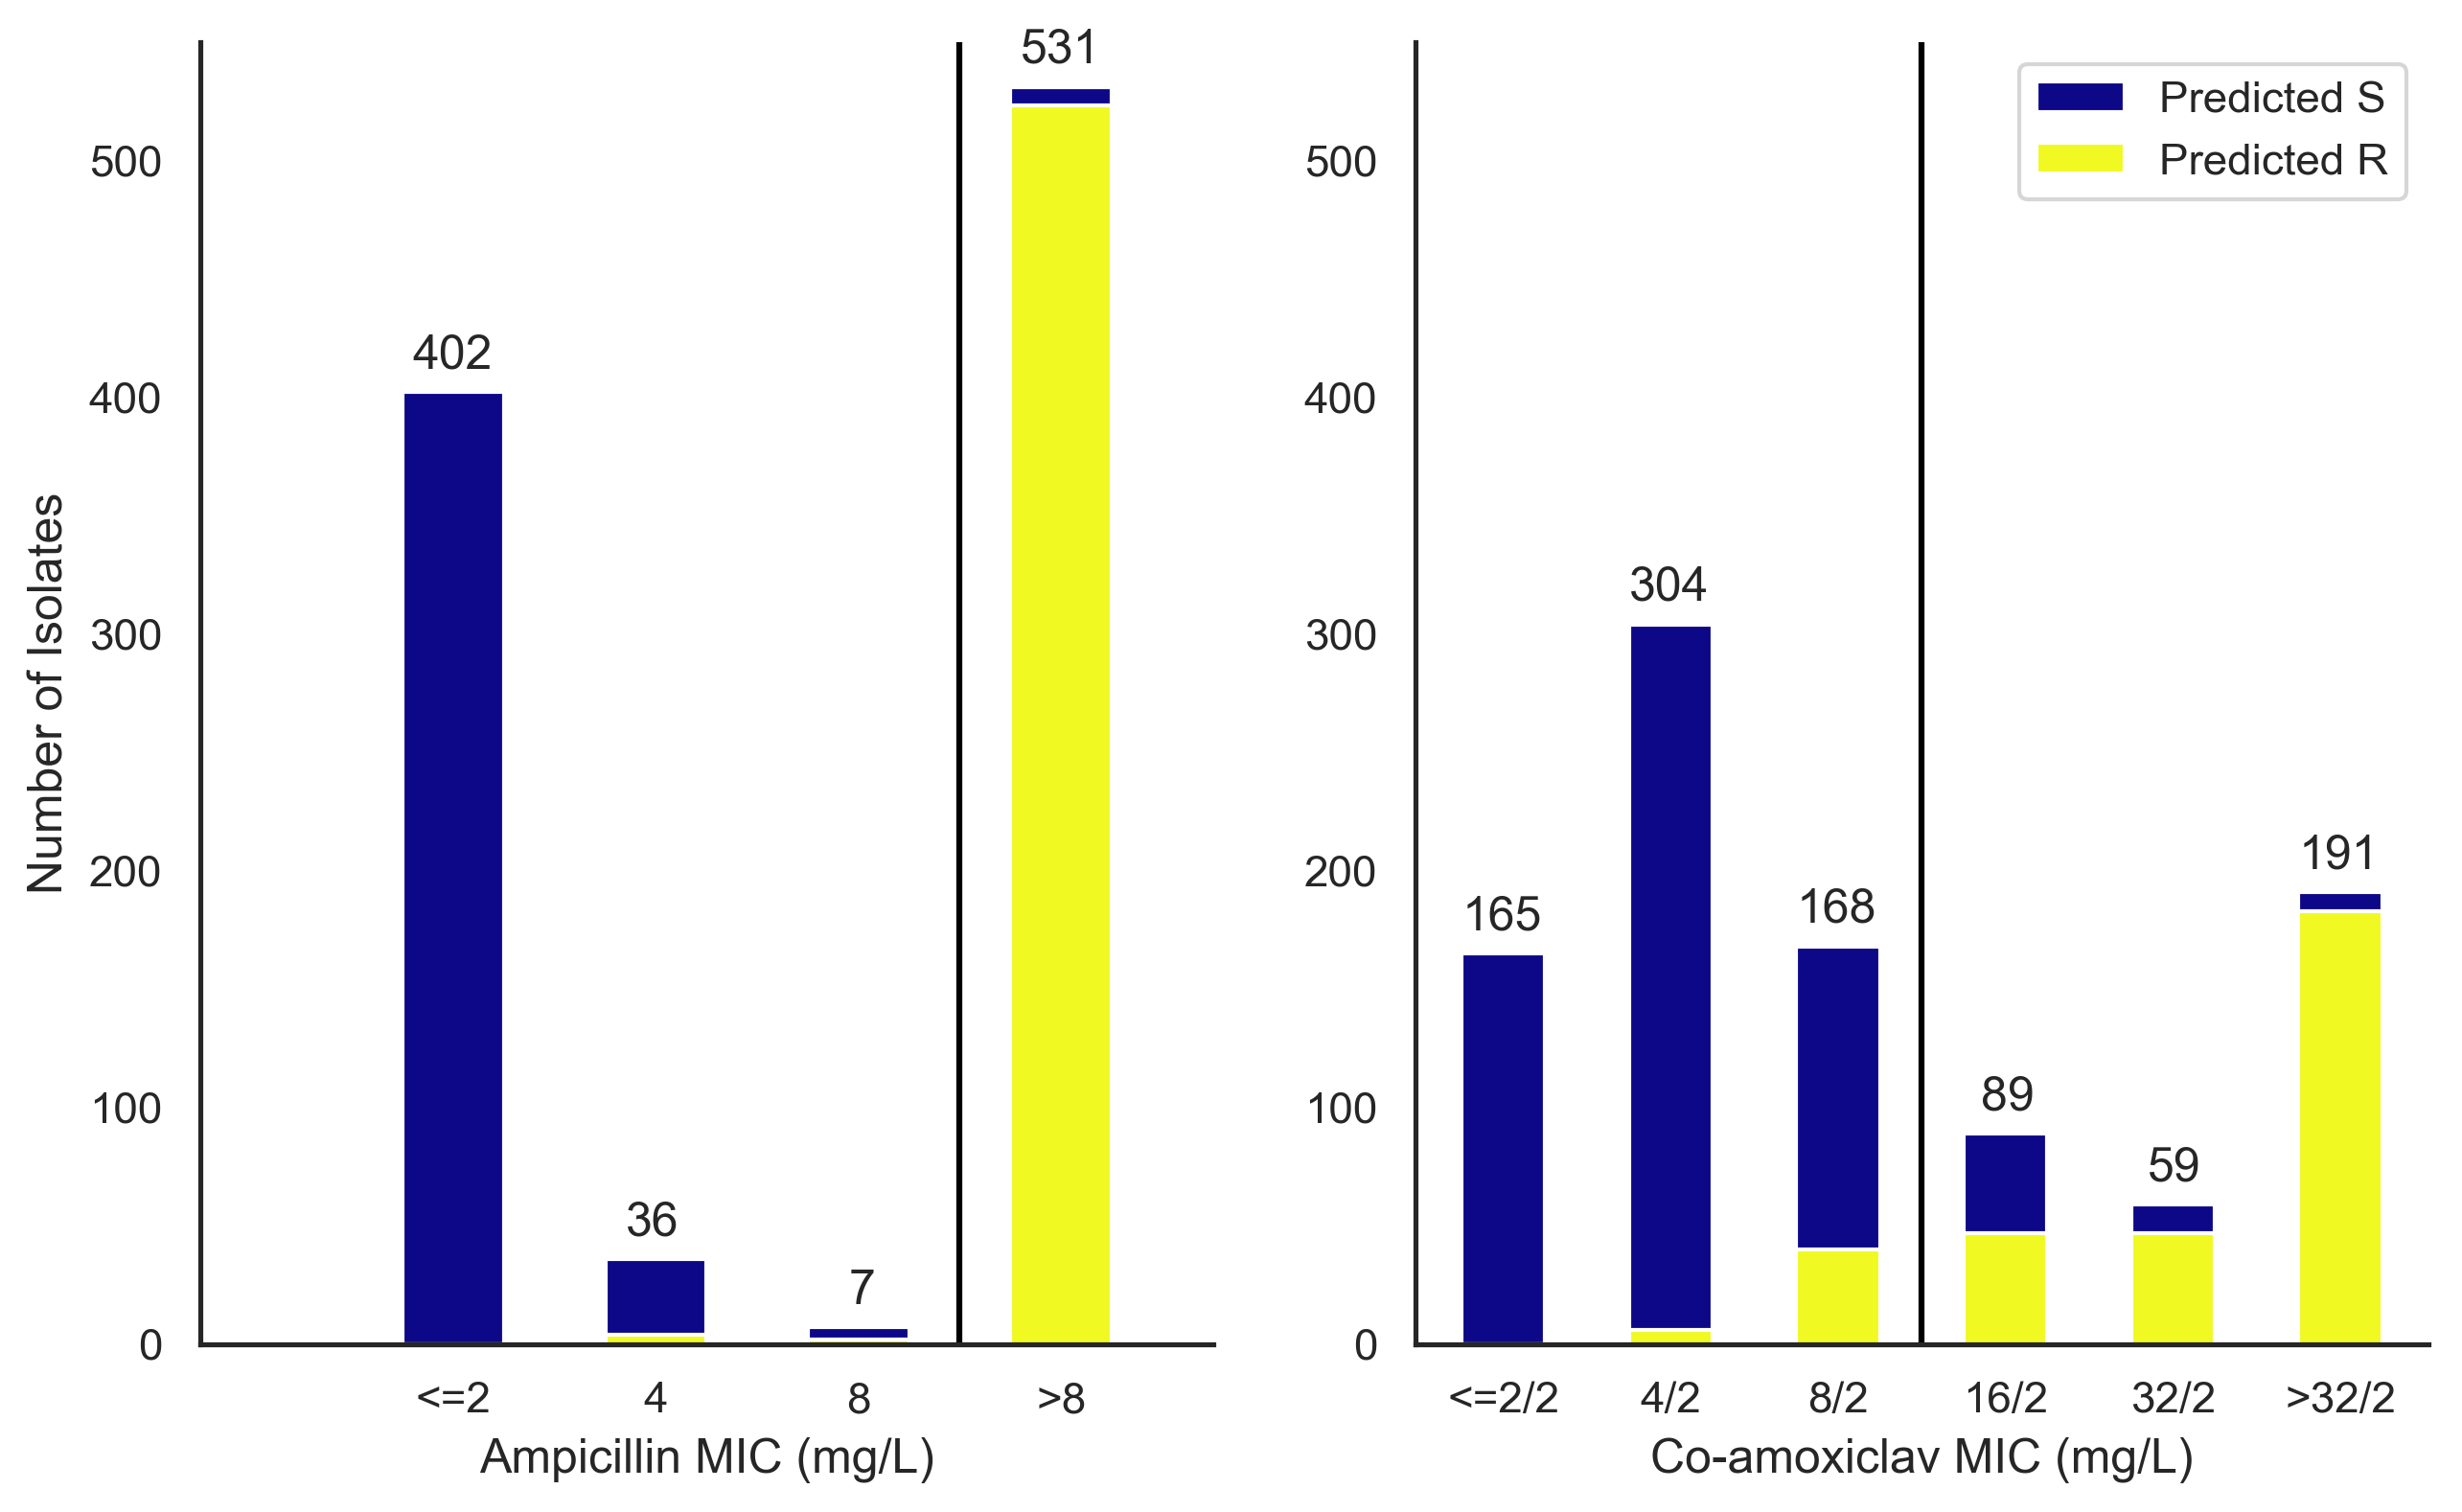

In [6]:
# Reproducing the prediction images

%matplotlib inline
# FIRSTLY WE WILL START WITH THE MAIN SET ANALYSIS
rule_df = pd.read_csv("resistance_predictions.csv")
rule_df.head()
mic_df = pd.read_csv("bd_phoenix_mics.csv")
mic_df = mic_df.rename(columns={"isolate":"guuid"})
full_df = rule_df.merge(mic_df, how="inner", on="guuid")

guuids = list(set(list(full_df['guuid'])))

# Now making the actual picture, Prediction performance by MIC across the whole dataset

sns.set(style="white")
dpi = 300
# Initialize the matplotlib figure
f  = plt.figure(figsize=(10,6), dpi=300)
ax1 = plt.subplot2grid((1,2),(0,0), rowspan = 1 , colspan= 1)
ax2 = plt.subplot2grid((1,2),(0,1), rowspan = 1 , colspan= 1)
sns.distplot( np.log2(full_df["newcoa_mic"]) , bins = [1,1.5, 2,2.5, 3,3.5,4,4.5,5,5.5,6,6.5],
            kde=False, color='#0d0887', label="Predicted S", ax=ax2, hist_kws={"alpha": 1})
sns.distplot(np.log2(full_df.loc[full_df.coa_extended == True].newcoa_mic),bins = [1,1.5, 2,2.5, 3,3.5,4,4.5,5,5.5,6,6.5],
            kde = False, color='#f0f921', label="Predicted R", ax=ax2, hist_kws={"alpha": 1})
sns.distplot( np.log2(full_df["newamp_mic"]) , bins = [1,1.5, 2,2.5, 3,3.5,4,4.5,5,5.5,6,6.5],
            kde=False, color='#0d0887',  ax=ax1 , hist_kws={"alpha": 1})
sns.distplot(np.log2(full_df.loc[full_df.amx_pred == True].newamp_mic),bins = [1,1.5, 2,2.5, 3,3.5,4,4.5,5,5.5,6,6.5],
            kde = False, color='#f0f921', ax=ax1, hist_kws={"alpha": 1})

ax1.text(1.05, len(full_df.loc[full_df["newamp_mic"] == 2]) + 10, len(full_df.loc[full_df["newamp_mic"] == 2]))
ax1.text(2.10, len(full_df.loc[full_df["newamp_mic"] == 4]) + 10, len(full_df.loc[full_df["newamp_mic"] == 4]))
ax1.text(3.20, len(full_df.loc[full_df["newamp_mic"] == 8]) + 10, len(full_df.loc[full_df["newamp_mic"] == 8]))
ax1.text(4.05, len(full_df.loc[full_df["newamp_mic"] == 16]) + 10, len(full_df.loc[full_df["newamp_mic"] == 16]))
ax2.text(1.0, len(full_df.loc[full_df["newcoa_mic"] == 2]) + 10, len(full_df.loc[full_df["newcoa_mic"] == 2]))
ax2.text(2.0, len(full_df.loc[full_df["newcoa_mic"] == 4]) + 10, len(full_df.loc[full_df["newcoa_mic"] == 4]))
ax2.text(3.0, len(full_df.loc[full_df["newcoa_mic"] == 8]) + 10, len(full_df.loc[full_df["newcoa_mic"] == 8]))
ax2.text(4.10, len(full_df.loc[full_df["newcoa_mic"] == 16]) + 10, len(full_df.loc[full_df["newcoa_mic"] == 16]))
ax2.text(5.10, len(full_df.loc[full_df["newcoa_mic"] == 32]) + 10, len(full_df.loc[full_df["newcoa_mic"] == 32]))
ax2.text(6.00, len(full_df.loc[full_df["newcoa_mic"] == 64]) + 10, len(full_df.loc[full_df["newcoa_mic"] == 64]))

ax1.set_xticks([1.25, 2.25, 3.25, 4.25])
ax1.set_xticklabels(["<=2", "4", "8", ">8"])
ax1.set_yticks([0, 100, 200, 300, 400, 500])
ax1.axvline(x=3.75, color='black')
ax1.set_xlabel("Ampicillin MIC (mg/L)")
ax1.set_xlim([0,5])
ax1.set_ylim([0, 550])
ax2.set_ylim([0, 550])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylabel("Number of Isolates")
ax2.set_xticks([1.25, 2.25, 3.25, 4.25, 5.25, 6.25])
ax2.set_xticklabels(["<=2/2", "4/2", "8/2", "16/2", "32/2", ">32/2"])
ax2.set_yticks([0, 100, 200, 300, 400, 500])
ax2.axvline(x=3.75, color='black')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xlabel("Co-amoxiclav MIC (mg/L)")
plt.legend()


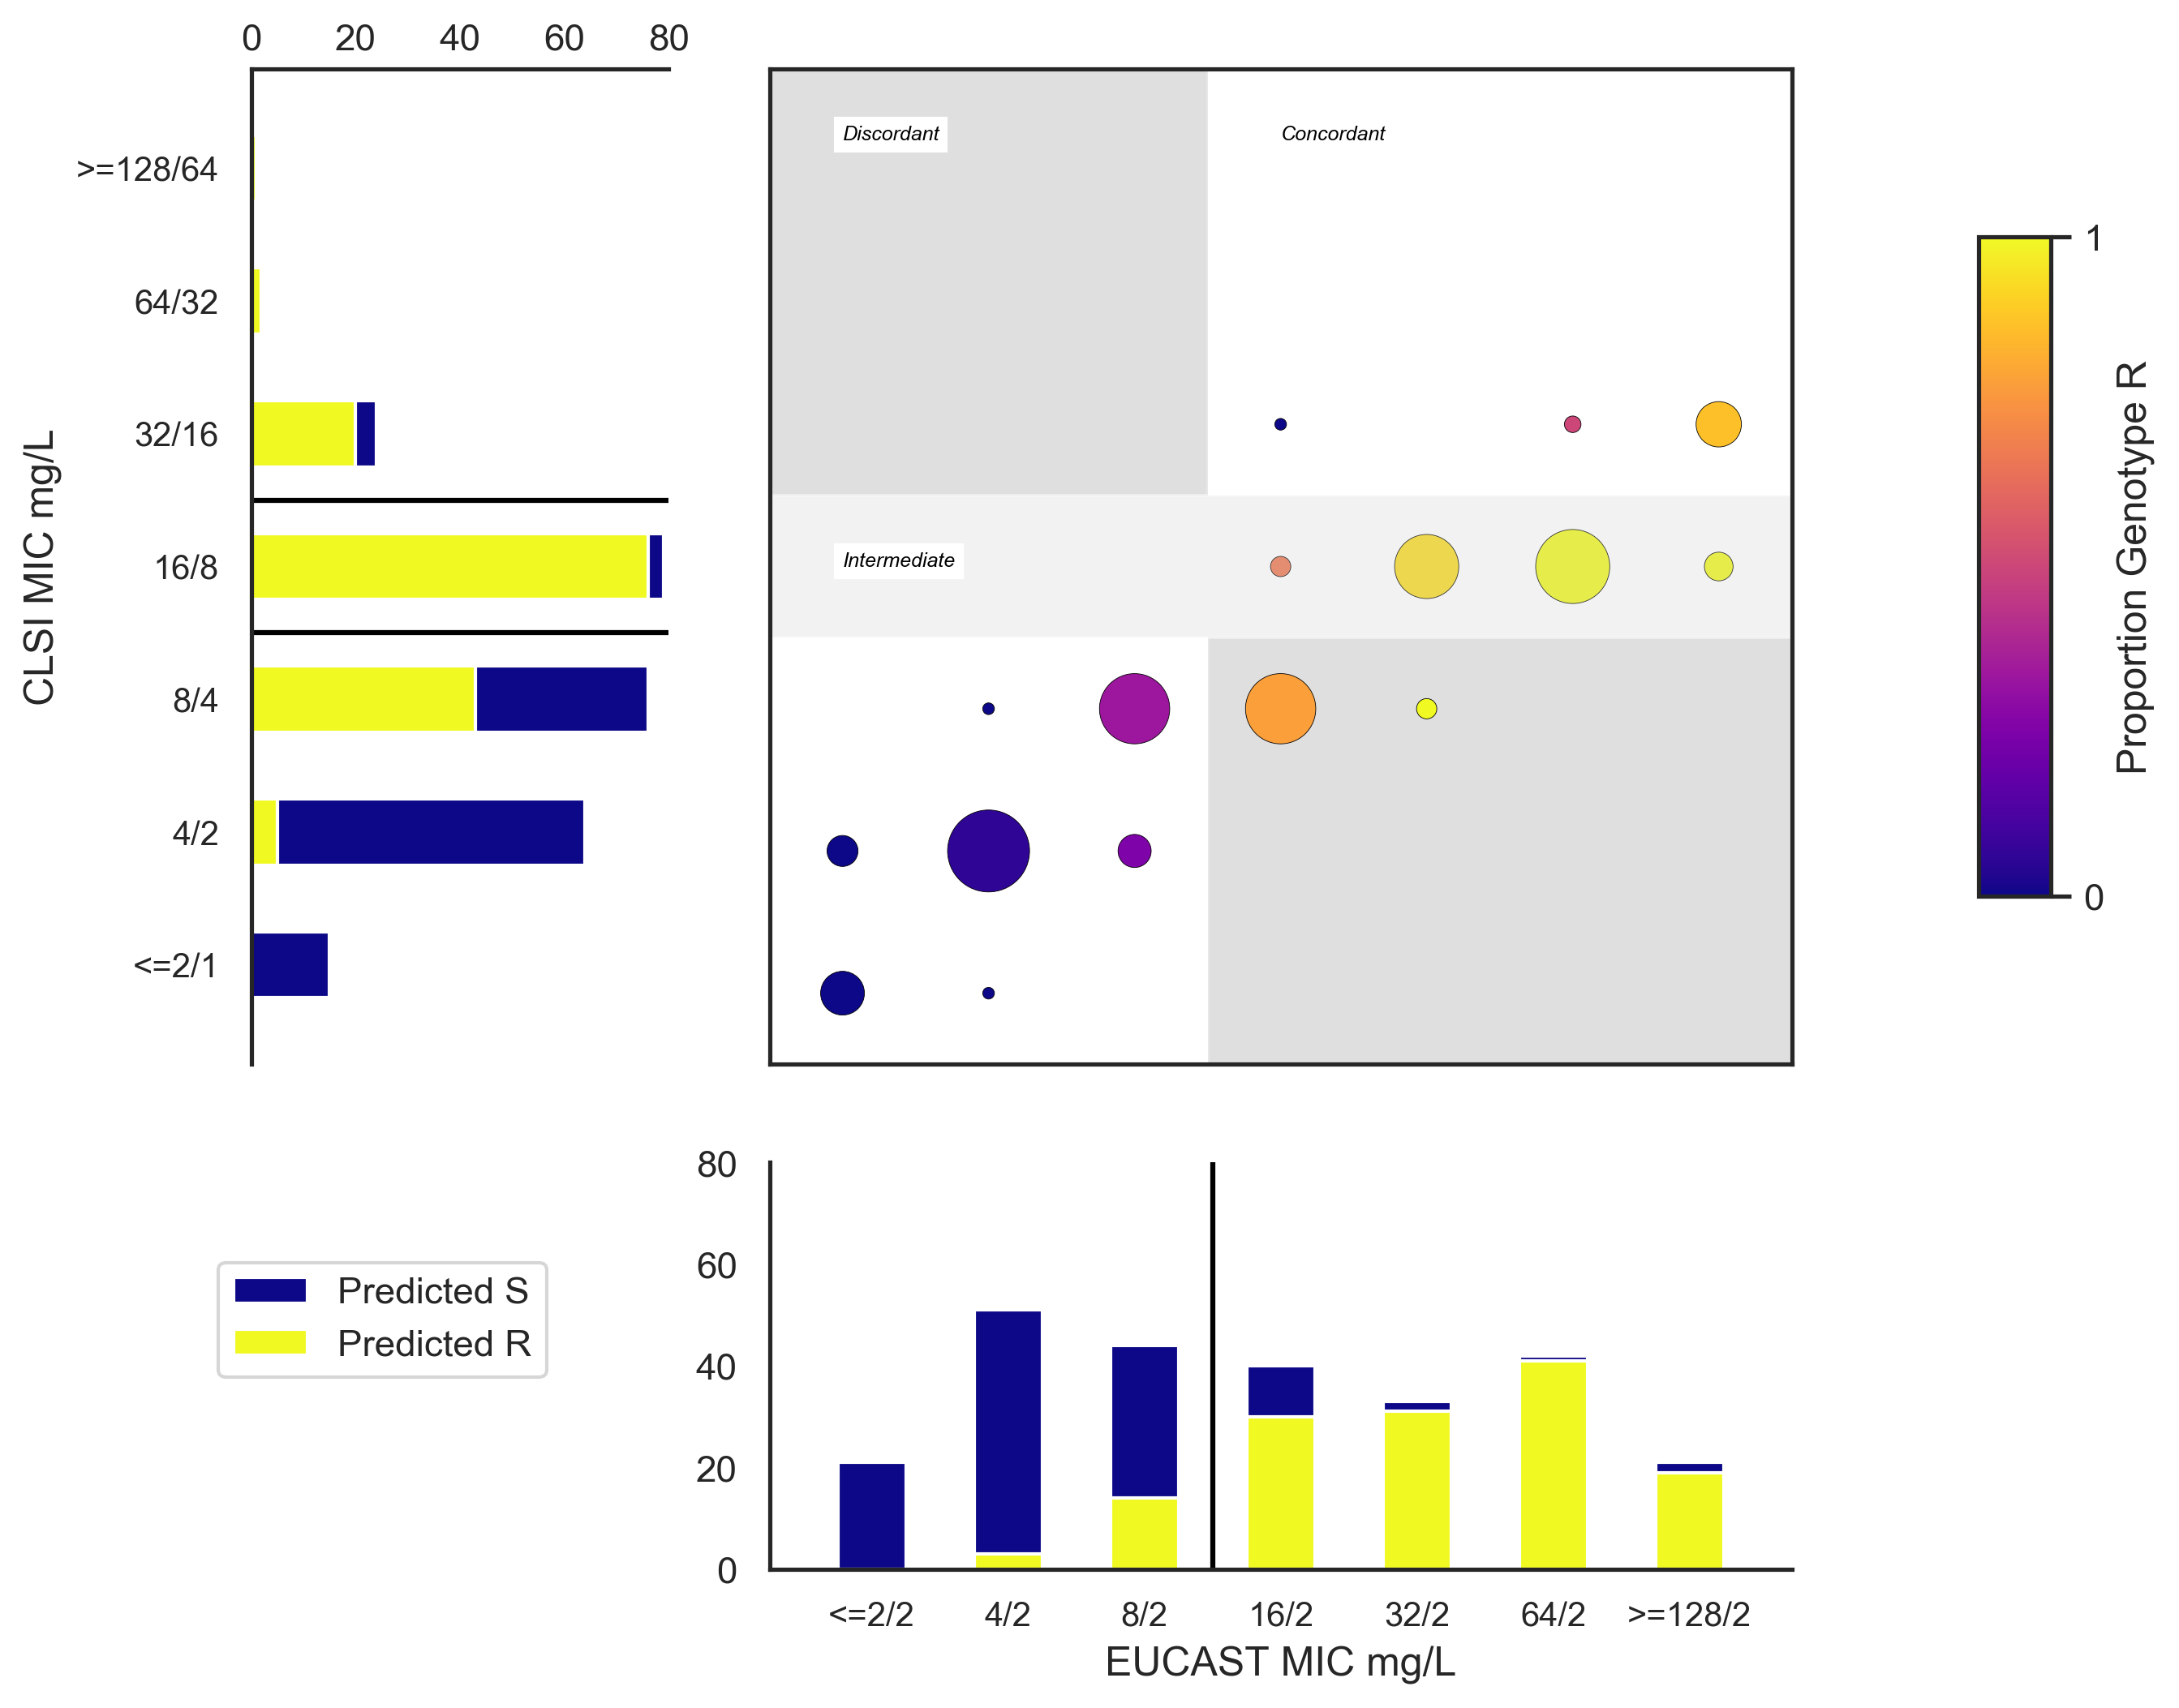

In [7]:
agar_df = pd.read_csv("agar_dilution_phenotypes.csv")
agar_df = agar_df.rename(columns={"isolate":"guuid"})

agar_df = pd.merge(agar_df, full_df, on="guuid", how="inner") 

feature = "coa_extended"
plt.close()
fig = plt.figure(figsize=(10,10), dpi=300)
ax1 = plt.subplot2grid((22,22),(0,6), rowspan = 12 , colspan= 12)
ax2 = plt.subplot2grid((22,22), (0,0), rowspan = 12, colspan = 5)
ax3 = plt.subplot2grid((22,22), (13,6), rowspan=5 , colspan = 12)
ax4 =  plt.subplot2grid((22,22), (2,20), rowspan=8 , colspan = 1)


x = []
y = []
areas = []
colors = []
x_intermed = []
y_intermed = []
x_orig = [0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0]
y_orig = [0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0]
for i in x_orig:
    for j in y_orig:
        x_intermed.append(i)
        y_intermed.append(j)
for i in range(len(x_intermed)):
    area_df = agar_df.loc[agar_df.eucast_mic == x_intermed[i]]
    area_df = area_df.loc[area_df.clsi_mic == y_intermed[i]]
    res_df = area_df.loc[area_df[feature] == True]
    res = len(res_df)
    area = len(area_df)
    if area != 0:
        x.append(x_intermed[i])
        y.append(y_intermed[i])
        areas.append(area * 12)
        color = res/area
        colors.append(color)
x= np.log2(x)
y = np.log2(y)
x_filrange1 = [i + 3.5 for i in range(10)]
x_filrange2 = [-5.5+ i for i in range(10)]
ax1.axhspan(3.5, 4.5, facecolor='0.8', alpha=0.25)
ax1.fill_between(x_filrange1, -10 , 3.5, facecolor='0.5', alpha=0.25)
ax1.fill_between(x_filrange2, 10 , 4.5, facecolor='0.5', alpha=0.25)

#Plotting the figure
main_ax = ax1.scatter(x, y, c=colors, s=areas, linewidths=2, edgecolor='black', cmap = 'plasma', lw=0.2)
    
#Graph Axes
ax1.set_xlim([0.5,7.5])
ax1.set_ylim([0.5,7.5])
ax1.set_xticks([]) 
ax1.set_yticks([])

cbar = fig.colorbar(main_ax, cax=ax4, ticks=[0,1])
cbar.set_label("Proportion Genotype R")

ax1.text(1.0,4, "Intermediate", color='black',
         fontsize=6,style='italic', bbox={'facecolor':'white', 'alpha':1 ,'pad':2 })
ax1.text(1.0,7.0, "Discordant", color='black',
         fontsize=6,style='italic', bbox={'facecolor':'white', 'alpha':1 ,'pad':2 })
ax1.text(4,7.0, "Concordant", color='black',
         fontsize=6,style='italic', bbox={'facecolor':'white', 'alpha':1 ,'pad':2 })

# for i in range(new_map.N):
#     rgb = new_map(i)[:3] # will return rgba, we take only first 3 so we get rgb
#     print(matplotlib.colors.rgb2hex(rgb))

sns.distplot( np.log2(agar_df.clsi_mic) , bins = [0, 0.5, 1,1.5, 2,2.5, 3,3.5,4,4.5,5,5.5,6,6.5, 7, 7.5, 8, 8.5],
            kde=False, color='#0d0887', label="Predicted S", ax=ax2, vertical=True, hist_kws={'alpha':1} )
sns.distplot( np.log2(agar_df.loc[agar_df[feature] ==True].clsi_mic) , bins = [0, 0.5, 1,1.5, 2,2.5, 3,3.5,4,4.5,5,5.5,6,6.5, 7, 7.5, 8, 8.5],
            kde=False, color='#f0f921', label="Predicted R", ax=ax2, vertical=True, hist_kws={'alpha':1})
sns.distplot( np.log2(agar_df.eucast_mic) , bins = [0, 0.5, 1,1.5, 2,2.5, 3,3.5,4,4.5,5,5.5,6,6.5, 7, 7.5, 8, 8.5],
            kde=False, color='#0d0887', label="Predicted S", ax=ax3, hist_kws={'alpha':1})
sns.distplot( np.log2(agar_df.loc[agar_df[feature] ==True].eucast_mic) , bins = [0, 0.5, 1,1.5, 2,2.5, 3,3.5,4,4.5,5,5.5,6,6.5, 7, 7.5, 8, 8.5],
            kde=False, color='#f0f921', label="Predicted R", ax=ax3, hist_kws={'alpha':1})

locs = [ 1.25,2.25,3.25,4.25,5.25,6.25,7.25]
xlabels =[ "<=2/2", "4/2", "8/2", "16/2" , "32/2", "64/2",  ">=128/2"]
ylabels = [ "<=2/1", "4/2", "8/4" ,"16/8","32/16","64/32",  ">=128/64"]
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax2.set_yticks(locs)
ax2.set_yticklabels(ylabels, fontsize=10)
ax2.set_ylabel("CLSI MIC mg/L")
ax2.xaxis.set_label_position('top')
ax2.xaxis.tick_top()
ax2.axhline(y=3.75, color='black')
ax2.axhline(y=4.75, color='black')
ax2.tick_params(axis="x", length=0)
ax2.set_ylim([0.5,8.0])
ax2.set_xlim([0, 80])
ax2.set_xticks([0,20,40,60,80])
ax3.set_xticks(locs)
ax3.set_xticklabels(xlabels, fontsize=10)
ax3.set_xlabel("EUCAST MIC mg/L")
ax3.axvline(x=3.75, color='black')
ax3.set_xlim([0.5,8.0])
ax3.set_ylim([0, 80])
ax3.legend(bbox_to_anchor=(-0.2, 0.8))